In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
import os
import sys
sys.path.append('../')

In [94]:
from model import UnicycleModel
from cost import UnicycleCost
from constraints import UnicycleConstraints
from scipy.integrate import solve_ivp
from matplotlib.patches import Ellipse
from utils.utils_alg import get_neighbor_vec,get_K_discrete
from utils.utils_plot import plot_traj,plot_traj_set,plot_state_input,plot_comparison

from trajopt import trajopt
from funlopt import funlopt
from Lipschitz import Lipschitz
from Scaling import TrajectoryScaling

from utils.utils_alg import get_sample_eta_w,propagate_model
import cvxpy as cvx
from scipy.integrate import solve_ivp



In [95]:
N = 30
tf = 5
delT = tf/N

## obstacle setting

In [96]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []


c_list.append([1.8,0.3])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([2*2/3,3.5])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([4.2,0.7])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([3.8,3.5])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([10*2/3,0.5])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([6.5,4])
H_list.append(get_H_obs(0.5,0.5))



c_list.append([4*2/3,1.7])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([8*2/3,2.3])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([0.5,2])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([8,2.3])
H_list.append(get_H_obs(0.5,0.5))


## initial and final conditions 

In [97]:
myModel = UnicycleModel.unicycle2('unicycle','numeric_central')

ix = myModel.ix
iu = myModel.iu
iw = myModel.iw
iq = myModel.iq
ip = myModel.ip

C = myModel.C
D = myModel.D
E = myModel.E
G = myModel.G

myCost = UnicycleCost.unicycle('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu)
myConst.set_obstacle(c_list,H_list)



In [98]:
xi = np.zeros(3)
xi[0] = 0.0
xi[1] = 0.0 
xi[2] = 0

xf = np.zeros(3)
xf[0] = 8.0
xf[1] = 4.0
xf[2] = 0

Qini = np.diag([0.4**2,0.4**2,np.deg2rad(20)**2])
Qf = np.diag([0.3**2,0.3**2,np.deg2rad(20)**2])

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
u0 = np.zeros((N+1,iu))

In [99]:
A,B,s,z,x_prop_n = myModel.diff_discrete_zoh(x0[0:N,:],u0[0:N,:],delT,tf) 
S = np.eye(ix)
R = 1*np.eye(iu)
K0 = get_K_discrete(A,B,S,R,S,N,ix,iu)
Q0 = np.tile(np.diag([0.35**2,0.35**2,np.deg2rad(10)**2]),(N+1,1,1))
Y0 = K0@Q0[:N]
betahat = np.ones(N+1)

In [100]:
x_max = np.array([10,10,np.pi])
x_min = np.zeros(ix)

u_max = np.array([5,5]) 
u_min = np.zeros(iu)

traj_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

x_max = np.array([1,1,np.pi])
x_min = np.zeros(ix)

u_max = np.array([5,5]) 
u_min = np.zeros(iu)

funl_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

In [101]:
traj_solver= trajopt('unicycle',N,tf,10,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e0,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=True)

Is DPP?  True


In [102]:
_,_,xnom,unom,_,total_num_iter,_,_,_,_,history_nom = traj_solver.run(x0,u0,xi,xf)
tnom = np.array(range(N+1))*delT

┌──────────────────────────────────────────────────────────────────────────────────────────────┐

│                                              ..:: SCP ::..                                   │

├──────┬───────────┬──────────┬─────────┬───────────┬────────────┬─────────┬─────────┬─────────┤

│ iter │  total    │ final    │ input   │     -     │ total cost │ vc      │ tr      │ dyn     │

│      │  cost     │ time [s] │ energy  │     -     │ reduction  │ (log10) │         │         │

├──────┼───────────┼──────────┼─────────┼───────────┼────────────┼─────────┼─────────┼─────────┤

│1     │4079.873   │5.000     │76.8     │0          │-4.08e+03   │0(0.60  )│0(3.073 )│0(0.354 )│
│2     │85.631     │5.000     │84.5     │0          │3.99e+03    │1(-13.04)│0(1.144 )│0(0.059 )│
│3     │104.699    │5.000     │105      │0          │-19.1       │1(-12.30)│0(0.092 )│0(0.004 )│
│4     │104.992    │5.000     │105      │0          │-0.292      │1(-12.45)│0(0.004 )│1(0.000 )│
│5     │104.803    │5.00

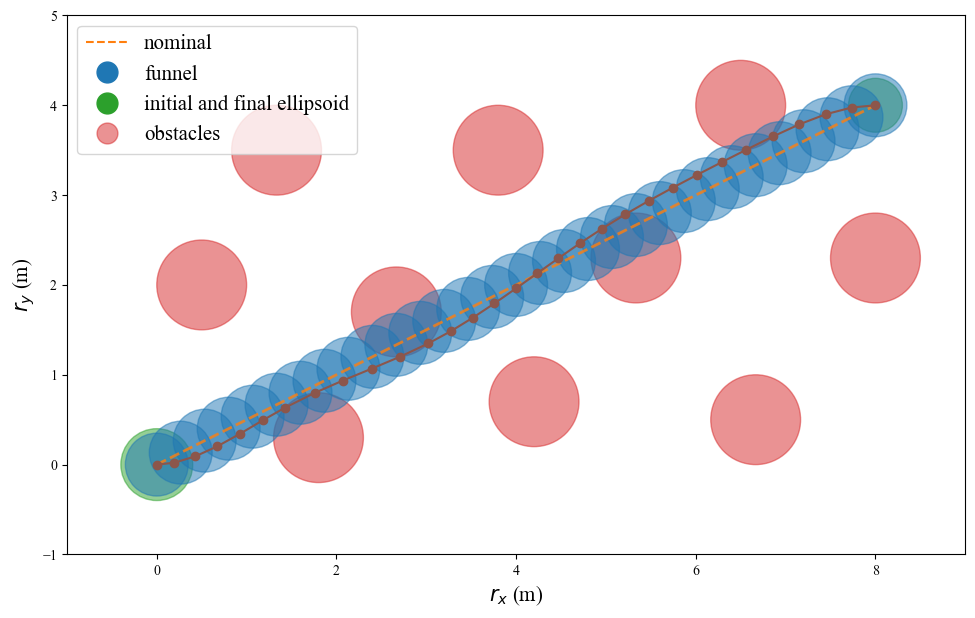

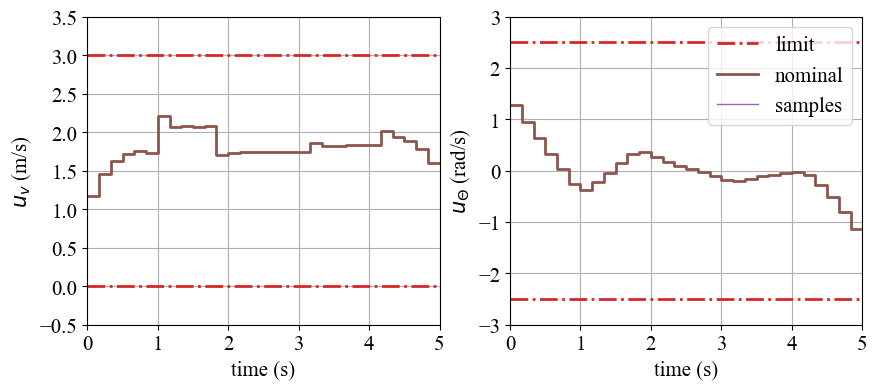

In [103]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(x0,u0,c_list,H_list,Q0,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
plt.plot(xnom[:,0],xnom[:,1],'o-',color='tab:brown',label='traj w/o funnel')
plt.axis([-1.0, 9.0, -1.0, 5.0])
plt.figure(1,figsize=(10,4))
plt.subplot(121)
plt.plot(tnom, unom[:,0]*0+myConst.vmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.plot(tnom, unom[:,0]*0+myConst.vmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.step(tnom, [*unom[:N,0],unom[N-1,0]],'-',color='tab:brown',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_v$ (m/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -0.5, 3.5])
plt.grid(True)

plt.subplot(122)
plt.plot(tnom, unom[:,1]*0+myConst.wmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.plot(tnom, unom[:,1]*0+myConst.wmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.step(tnom, [*unom[:N,1],unom[N-1,1]],'-',color='tab:brown',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_{\Theta}$ (rad/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -3, 3])
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)

## run

In [122]:
total_iter = 40
max_iter_trajopt = 1

tol_funl = 1e-8
tol_traj = 1e-8
tol_vc = 1e-8
tol_dyn = 1e-8

traj_solver= trajopt('unicycle',N,tf,max_iter_trajopt,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e0,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=False)

funl_solver = funlopt(ix,iu,iq,ip,iw,N,myCost.S,myCost.R,funl_scaling,
                      alpha=0.99,
                      lambda_mu=0.1,
                      w_tr=1e-4,
                      flag_nonlinearity=True)
funl_solver.cvx_initialize(Qini,Qf)
lip_estimator = Lipschitz(ix,iu,iq,ip,iw,N,num_sample=100,flag_uniform=True)

from jointsynthesis import jointsynthesis
JS = jointsynthesis(myModel,traj_solver,funl_solver,lip_estimator,total_iter,
                   tol_traj,tol_funl,tol_vc,tol_dyn,verbosity=True)

Is DPP?  True
nonlinear funnel
Is DPP?  True


In [111]:
history = JS.run(xi,xf,x0,u0,Q0,Y0,K0)

|iter| traj_cost | funl_cost |   vc   |   Delta_T   |   Delta_F   | e_prop  |gamma diff|
|    |           |           | log10  |   log10     |   log10     | log10   |          |
|1   |76.461     |7.039      |0.708(0)|1.9       (0)|2.6       (0)|0.692(0)|0.60447006|
|2   |165.922    |6.751      |-0.963(0)|2.04      (0)|1.61      (0)|0.327(0)|0.16306881|
|3   |141.880    |6.280      |-12.9(1)|1.7       (0)|1.33      (0)|0.196(0)|0.21213037|
|4   |145.337    |6.090      |-12.3(1)|0.927     (0)|0.674     (0)|-0.435(0)|0.10365253|
|5   |151.621    |5.979      |-11.9(1)|0.0856    (0)|-0.338    (0)|-1.878(0)|0.04610660|
|6   |149.878    |5.905      |-13.2(1)|-0.185    (0)|-0.875    (0)|-2.008(0)|0.02859223|
|7   |149.240    |5.882      |-10.7(1)|-0.401    (0)|-1.06     (0)|-2.213(0)|0.02289368|
|8   |148.716    |5.882      |-12.1(1)|-0.456    (0)|-1.32     (0)|-2.278(0)|0.01633476|
|9   |148.894    |5.894      |-13.1(1)|-0.647    (0)|-1.53     (0)|-2.459(0)|0.01176586|
|10  |149.090    |5.910

In [112]:
history[0]['gamma']

array([0.02095682, 0.02095673, 0.02095659, 0.02095641, 0.02097381,
       0.02098451, 0.02886924, 0.01131455, 0.03492713, 0.01831439,
       0.0183185 , 0.01831021, 0.01570067, 0.01569958, 0.01569544,
       0.01568759, 0.01567515, 0.0156569 , 0.0236356 , 0.02360053,
       0.02353524, 0.02164015, 0.02153154, 0.02138688, 0.02125843,
       0.02031661, 0.02001358, 0.01964466, 0.01921631, 0.0187363 ])

In [113]:
del_traj_list = [history[i]['traj_diff'] for i in range(len(history))]
del_funl_list = [history[i]['funl_diff'] for i in range(len(history))]
vc_list = [history[i]['vc'] for i in range(len(history))]
dyn_error_list = [history[i]['dyn_error'] for i in range(len(history))]

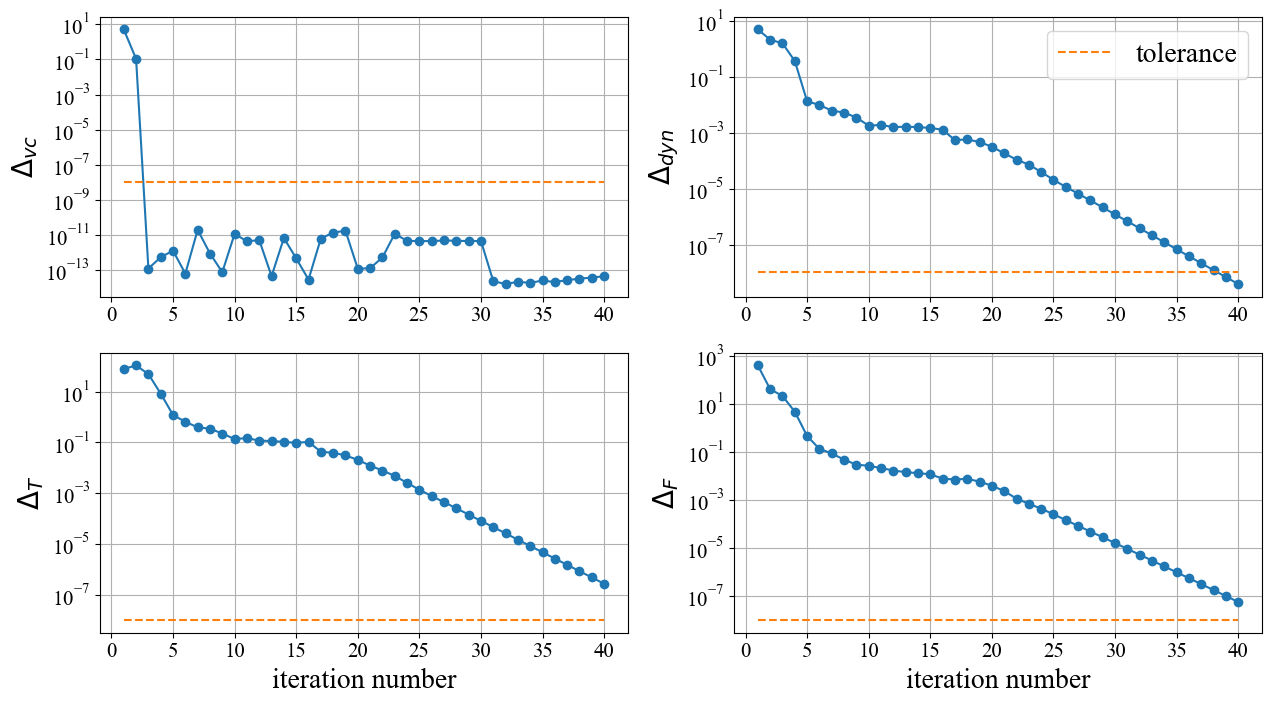

In [114]:
i_index = np.array([i+1 for i in range(len(history))])
fS = 20
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.plot(i_index,vc_list,'o-')
plt.plot(i_index,i_index*0+tol_vc,'--')
# plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_{vc}$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(222)
plt.plot(i_index,dyn_error_list,'o-')
plt.plot(i_index,i_index*0+tol_dyn,'--',label='tolerance')
# plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_{dyn}$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=fS)


plt.subplot(223)
plt.plot(i_index,del_traj_list,'o-')
plt.plot(i_index,i_index*0+tol_traj,'--')
plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_T$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(224)
plt.plot(i_index,del_funl_list,'o-')
plt.plot(i_index,i_index*0+tol_funl,'--')
plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_F$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)


# plt.savefig('../images/convergence_result.pdf')

# Computational time

In [115]:
time_derivs = []
time_trajopt = []
time_funlopt = []
time_lipschitz = []

for his in history :
    time_derivs.append(his['t_derivs'])
    time_trajopt.append(his['t_trajopt'])
    time_funlopt.append(his['t_funlopt'])
    time_lipschitz.append(his['t_Lipschitz'])
def mean_list(l) :
    return sum(l)/len(l)
mean_derivs = mean_list(time_derivs)
mean_trajopt = mean_list(time_trajopt)
mean_funlopt = mean_list(time_funlopt)
mean_lipschitz = mean_list(time_lipschitz)
print("mean_derivs",mean_derivs)
print("mean_trajopt",mean_trajopt)
print("mean_funlopt",mean_funlopt)
print("mean_lipschitz",mean_lipschitz)

mean_derivs 0.006219971179962158
mean_trajopt 0.05767012238502502
mean_funlopt 4.210812002420425
mean_lipschitz 1.0110922873020172


# Evaluate the generated traj and funl

In [116]:
from utils.utils_alg import forward_full_with_K,get_sample_trajectory
import scipy

In [117]:
xbar = history[-1]['x']
ubar = history[-1]['u']
Qbar = history[-1]['Q']
Ybar = history[-1]['Y']
Kbar = history[-1]['K']
gammabar = history[-1]['gamma']

(-1.0, 9.0, -1.0, 5.0)

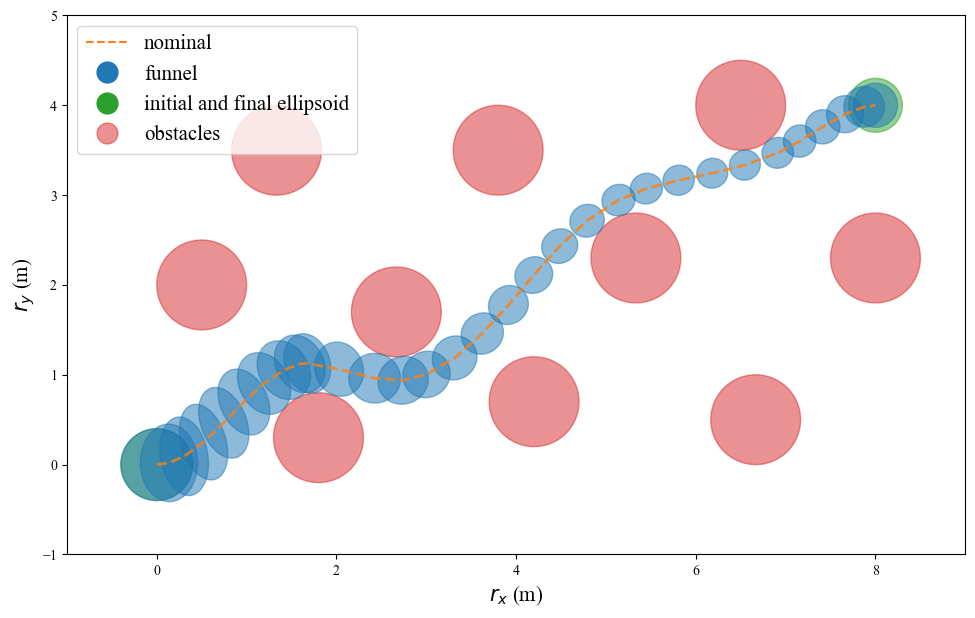

In [118]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1.0, 9.0, -1.0, 5.0])

# comparison with linear case

In [123]:
traj_solver= trajopt('unicycle',N,tf,max_iter_trajopt,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e0,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=False)

funl_solver = funlopt(ix,iu,iq,ip,iw,N,myCost.S,myCost.R,funl_scaling,
                      alpha=0.99,
                      lambda_mu=0.1,
                      w_tr=1e-4,
                      flag_nonlinearity=False)
funl_solver.cvx_initialize(Qini,Qf)
lip_estimator = Lipschitz(ix,iu,iq,ip,iw,N,num_sample=100,flag_uniform=True)

from jointsynthesis import jointsynthesis
JS = jointsynthesis(myModel,traj_solver,funl_solver,lip_estimator,total_iter,
                   tol_traj,tol_funl,tol_vc,tol_dyn,verbosity=True)

Is DPP?  True
linear funnel
Is DPP?  True


In [124]:
history_linear = JS.run(xi,xf,x0,u0,Q0,Y0,K0)

|iter| traj_cost | funl_cost |   vc   |   Delta_T   |   Delta_F   | e_prop  |gamma diff|
|    |           |           | log10  |   log10     |   log10     | log10   |          |
|1   |76.461     |5.012      |0.708(0)|1.9       (0)|2.58      (0)|0.692(0)|0.60447006|
|2   |138.695    |4.225      |-13.2(1)|1.9       (0)|1.7       (0)|0.261(0)|0.29978085|
|3   |122.312    |4.273      |-11.2(1)|1.49      (0)|1.25      (0)|-0.109(0)|0.11122323|
|4   |129.246    |4.311      |-13  (1)|0.526     (0)|0.503     (0)|-1.055(0)|0.05264101|
|5   |131.509    |4.316      |-12.6(1)|-0.0426   (0)|-0.46     (0)|-1.921(0)|0.01702361|
|6   |130.847    |4.352      |-12.5(1)|-0.13     (0)|-0.403    (0)|-1.940(0)|0.00959509|
|7   |131.416    |4.369      |-12.5(1)|-0.536    (0)|-0.941    (0)|-2.344(0)|0.01185335|
|8   |131.790    |4.376      |-12.3(1)|-1.16     (0)|-1.57     (0)|-3.017(0)|0.00598744|
|9   |132.097    |4.379      |-13.1(1)|-1.17     (0)|-1.58     (0)|-2.964(0)|0.00419787|
|10  |132.549    |4.379

In [125]:
xbar_linear = history_linear[-1]['x']
ubar_linear = history_linear[-1]['u']
Qbar_linear = history_linear[-1]['Q']
Ybar_linear = history_linear[-1]['Y']
Kbar_linear = history_linear[-1]['K']

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5')])

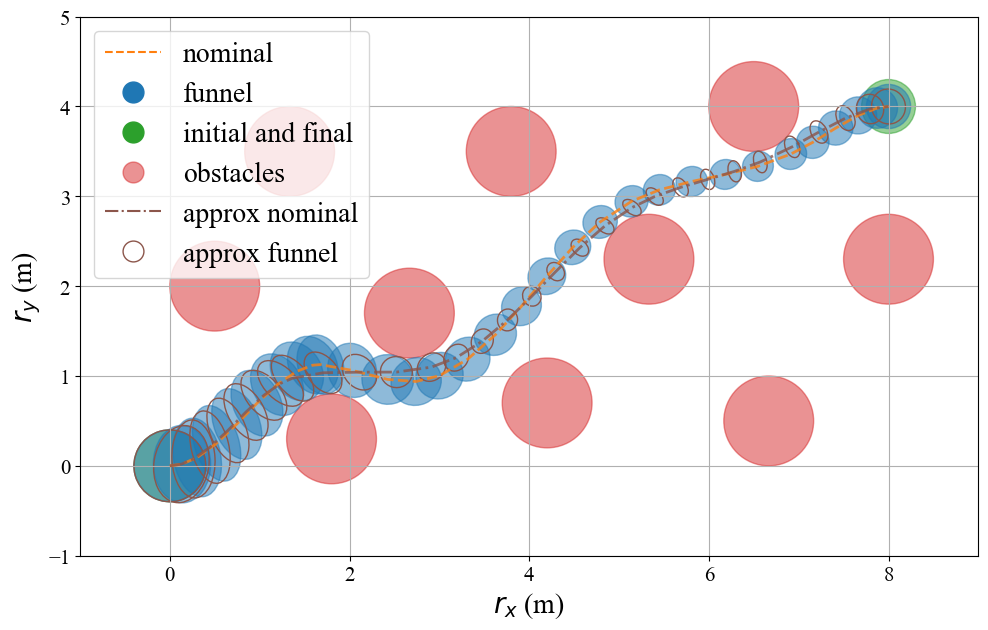

In [126]:
fS = 20
plt.figure(0,figsize=(15,7))
plot_comparison(xbar,xbar_linear,c_list,H_list,Qbar,Qbar_linear,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,fS=fS)
plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1.0, 9.0, -1.0, 5.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Sample from initial set

In [127]:
x0_sample = []
num_sample = 100
for i in range(num_sample) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    # z = np.array([0,1,0])
    x_s = xbar[0] + scipy.linalg.sqrtm(Qbar[0])@z
    x0_sample.append(x_s)
    
tsam,xsam,usam,wsam,xsamp = get_sample_trajectory(xi,x0_sample,xbar,ubar,Qbar,Ybar,myModel,N,ix,iu,iw,delT,
                                            flag_noise=True)

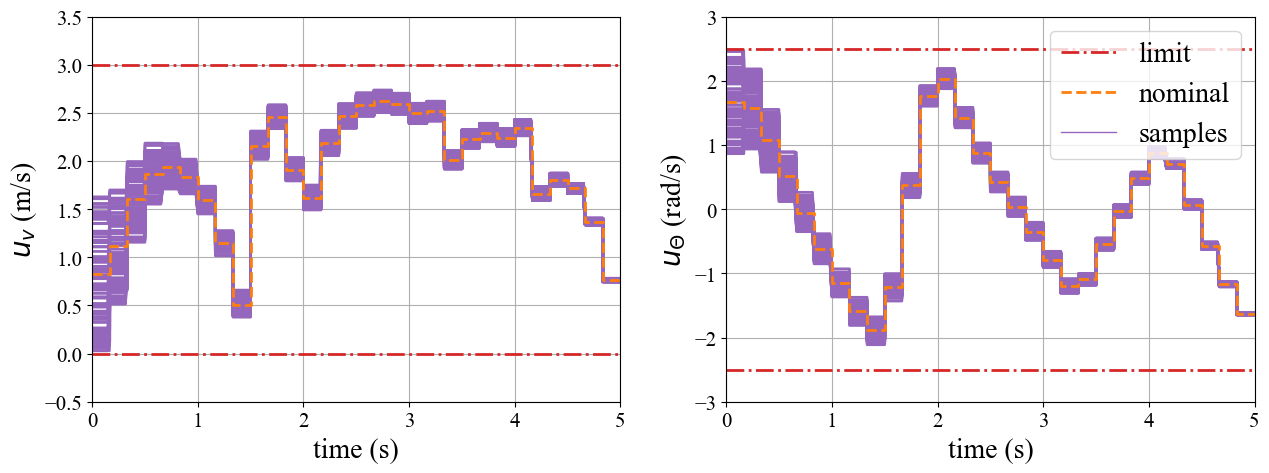

In [128]:
fS = 20
plt.figure(0,figsize=(15,5))
alpha = 1.0
t_index = np.array(range(N+1))*delT
for i in range(num_sample) :
    tsam_e = tsam[i]
    xsam_e = xsam[i]
    usam_e = usam[i]
#     plot_state_input(tsam_e,xsam_e,usam_e,None,None,N,delT,alpha,plt,flag_step=False)

    plt.subplot(121)
    plt.plot(tsam_e, usam_e[:,0],color='tab:purple',alpha=alpha,linewidth=2.0)
    plt.subplot(122)
    plt.plot(tsam_e, usam_e[:,1],color='tab:purple',alpha=alpha,linewidth=2.0)
plt.subplot(121)
plt.plot(tsam_e, usam_e[:,0]*0+myConst.vmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.plot(tsam_e, usam_e[:,0]*0+myConst.vmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.step(t_index, [*ubar[:N,0],ubar[N-1,0]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_v$ (m/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -0.5, 3.5])
plt.grid(True)
plt.subplot(122)
plt.plot(tsam_e, usam_e[:,1]*0+myConst.wmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.plot(tsam_e, usam_e[:,1]*0+myConst.wmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.step(t_index, [*ubar[:N,1],ubar[N-1,1]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_{\Theta}$ (rad/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -3, 3])
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)


In [ ]:
fS = 20
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True,fS=fS)
# for xsam_e in xsam :
for xsam_e in xsamp :
    plt.plot(xsam_e[:,0], xsam_e[:,1],'o-',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
plt.plot(1e3,1e3,'o-',color='tab:purple',label='samples')
# plt.plot(xnom[:,0],xnom[:,1],'-.',color='tab:brown',label='traj w/o funnel')
plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1.0, 9.0, -1.0, 5.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig('../images/traj_result_new.pdf')

In [ ]:
fS = 20
plt.figure(0,figsize=(10,5))
alpha = 0.5
t_index = np.array(range(N+1))*delT
for i in range(num_sample) :
    tsam_e = tsam[i]
    xsam_e = xsam[i]
    wsam_e = wsam[i]
#     plot_state_input(tsam_e,xsam_e,usam_e,None,None,N,delT,alpha,plt,flag_step=False)
    plt.subplot(121)
    plt.plot(tsam_e, wsam_e[:,0],color='tab:purple',alpha=alpha,linewidth=1.0)
    plt.subplot(122)
    plt.plot(tsam_e, wsam_e[:,1],color='tab:purple',alpha=alpha,linewidth=1.0)
plt.subplot(121)
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('w1 (m)', fontsize = fS)
plt.axis([0.0, tf, -2, 2])
plt.subplot(122)
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('w2 (m)', fontsize = fS)
plt.axis([0.0, tf, -2, 2])
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
# plt.savefig('../images/disturbance.pdf')

In [ ]:
fS = 15
plt.figure(0,figsize=(4,4))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=False)
for xsam_e in xsamp :
    plt.plot(xsam_e[:,0], xsam_e[:,1],'o',markersize=1.0, linewidth=1.0,alpha=1.0,color='tab:purple')
plt.plot(1e3,1e3,'o-',color='tab:purple',label='samples')
# plt.plot(xnom[:,0],xnom[:,1],'-.',color='tab:brown',label='traj w/o funnel')
# plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([3.7, 5.7, 1.5, 3.5])
plt.axis('off')
# plt.savefig('../images/traj_result_new_expansion.pdf')

In [ ]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True)
for xsam_e in xsamp :
    plt.plot(xsam_e[:,0], xsam_e[:,1],'o',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
#     plt.plot(xsam_e[1,0], xsam_e[1,1],'o',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
plt.plot(1e3,1e3,'o-',color='tab:purple',label='samples')
# plt.plot(xnom[:,0],xnom[:,1],'-.',color='tab:brown',label='traj w/o funnel')
# plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1, 1, -1, 1])
# plt.savefig('../images/traj_result.pdf')

In [ ]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True)
for xsam_e in xsamp :
    plt.plot(xsam_e[:,0], xsam_e[:,1],'o',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
#     plt.plot(xsam_e[1,0], xsam_e[1,1],'o',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
plt.plot(1e3,1e3,'o-',color='tab:purple',label='samples')
# plt.plot(xnom[:,0],xnom[:,1],'-.',color='tab:brown',label='traj w/o funnel')
# plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([7, 9, 3, 5])
# plt.savefig('../images/traj_result.pdf')

# sample from approx funnel

In [ ]:
x0_sample = []
for i in range(num_sample) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    x_s = xbar_linear[0] + scipy.linalg.sqrtm(Qbar_linear[0])@z
    x0_sample.append(x_s)
tsam_linear,xsam_linear,usam_linear,wsam_linear,xsamp_linear = get_sample_trajectory(xi,x0_sample,
                                                                    xbar_linear,ubar_linear,
                                                                    Qbar_linear,Ybar_linear,myModel,N,ix,iu,iw,delT,
                                                                    flag_noise=True)

In [ ]:
def get_radii_list(xsamp,xbar,Qbar) :
    radii_list = []
    for x in xsamp :
        radii = np.zeros(N+1)
        for i in range(N+1) :
            radii[i] = (x[i]-xbar[i]).T@np.linalg.inv(Qbar[i])@(x[i]-xbar[i])
            if radii[i] > 1 + 1e-8 :
                print("invariance violation",i,radii[i])
        radii_list.append(radii)
    return radii_list
radii_list = get_radii_list(xsamp,xbar,Qbar)
radii_list_linear = get_radii_list(xsamp_linear,xbar_linear,Qbar_linear)

In [ ]:
fS = 20
idx_plot = [i for i in range(N+1)]
fig, ax = plt.subplots(figsize=[10, 5])
for radii in radii_list_linear :
    ax.plot(idx_plot,radii,color='tab:brown',alpha=0.9)
for radii in radii_list :
    ax.plot(idx_plot,radii,'--',color='tab:purple',alpha=0.8)
ax.plot(idx_plot,radii*0+1,'-.',color='tab:red',alpha=1.0,label='limit')
plt.xlabel('$k$', fontsize = fS)
plt.ylabel('$r^Q_k$', fontsize = fS)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0,30,-0.2,1.2])
plt.plot(1e3,1e3,'--',color='tab:purple',alpha=1.0,label='proposed')
plt.plot(1e3,1e3,color='tab:brown',alpha=1.0,label='approx')
plt.legend(fontsize=fS)
# axins = ax.inset_axes([5, 15, 0.0, 0.6])
# axins = ax.inset_axes([0.2, 0.05, 0.3, 0.5])

# for radii in radii_list_linear :
#     axins.plot(idx_plot,radii,color='tab:brown',alpha=0.9)
# for radii in radii_list :
#     axins.plot(idx_plot,radii,'--',color='tab:purple',alpha=0.8)
# axins.plot(idx_plot,radii*0+1,'-.',color='tab:red',alpha=1.0,label='limit')

# axins.set_xlim(0.5, 4.5)
# axins.set_ylim(0.9, 1.1)
# axins.set_xticklabels([])
# axins.set_yticklabels([])
ax.indicate_inset_zoom(axins, edgecolor="black",linewidth=2.0)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"

# Search the case of violating the invariance

In [ ]:
from scipy.integrate import solve_ivp
def dfdt(t,x,u,w) :
    return np.squeeze(myModel.forward_uncertain(x,u,w))

num_test = 100
for i in range(num_test) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    x_s = xbar[0] + scipy.linalg.sqrtm(Qbar[0])@z
    
    u = ubar[0] + Kbar[0]@(x_s-xbar[0])
    
    z = np.random.randn(iw)
    w = z / np.linalg.norm(z)
#     w = np.array([1,0])
    
    sol = solve_ivp(dfdt,(0,delT),x_s,args=(u,w),max_step=delT/10,method='RK45',rtol=1e-6,atol=1e-10)
    
    xnew = sol.y[:,-1]
    radi_next = (xnew-xbar[1]).T@np.linalg.inv(Qbar[1])@(xnew-xbar[1])
    if radi_next > 1 :
        print("found!",radi_next)
        break
    if i == num_test - 1 :
        print("no case")
        
    
    

In [ ]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar[0:2],ubar[0:2],c_list,H_list,Qbar[0:2],xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True)
plt.plot(xnew[0], xnew[1],'o',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
plt.plot(1e3,1e3,'o-',color='tab:purple',label='samples')
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1, 1, -1, 1])